# Capstone - FEMA Recovery Regression Analysis

### By Rachel Beery

## Overview

**For my capstone I want to study community resilency and predict hazard mitigation success. I will be using the OpenFEMA datasets. My project will use supervised learning linear regression modeling to predict hazard mitigation success.**

**In this project we are using a regression analysis model to understand the ROI of hazard mitigation costs in USD. By understanding these patterns we will then provide recommendations on how to better allocate hazard mitigation funds in the future.**

Source: https://www.fema.gov/about/openfema/data-sets

### Goals: 
- Make a linear regression to see if there is a pattern overtime in hazard mitigation.
- Make a linear regression to see if there is a pattern overtime in recovery funds.
- Somehow bring these two together to see if certain hazard mitigation had more ROI
- Make categoricals for years

# Data Exploration and Cleaning

In [1]:
# We will begin by importing all of the packages we anticipate to use
import pandas as pd
import pandas.tseries  
import numpy as np  

import statsmodels.api as sm 
import itertools

import matplotlib.pyplot as plt   
from matplotlib.pylab import rcParams 
%matplotlib inline
import matplotlib.ticker as mtick
plt.style.use('ggplot') 
import plotly.express as px
import plotly.figure_factory as ff 
import plotly.graph_objects as go 
import seaborn as sns  

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore') 

import math
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
linreg = LinearRegression()

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [2]:
# Setting the display defaults
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows',)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Import data and see the headers
df = pd.read_csv(r"PublicAssistanceFundedProjectsDetails.csv")
df.head()

,disasterNumber,declarationDate,incidentType,pwNumber,applicationTitle,applicantId,damageCategoryCode,dcc,damageCategory,projectSize,county,countyCode,state,stateCode,stateNumberCode,projectAmount,federalShareObligated,totalObligated,obligatedDate,hash,lastRefresh,id
0,1239,1998-08-26T04:00:00.000Z,Severe Storm(s),41,Not Provided,463-99463-00,C - Roads and Bridges,C,Roads and Bridges,Small,Uvalde,463.000,Texas,TX,48,1489.980,1117.490,1158.770,1998-10-23T11:29:35.000Z,d6d9d778ca297d0fc97b04dfbc9ce269,2020-06-15T11:18:39.461Z,5ee7590f556129600dd511bd
1,1239,1998-08-26T04:00:00.000Z,Severe Storm(s),51,Not Provided,463-99463-00,C - Roads and Bridges,C,Roads and Bridges,Small,Uvalde,463.000,Texas,TX,48,11300.000,8475.000,8788.010,1998-10-23T11:29:35.000Z,b134f5a24c808f0b3e4330a8e7833c98,2020-06-15T11:18:39.474Z,5ee7590f556129600dd511be
2,1239,1998-08-26T04:00:00.000Z,Severe Storm(s),43,Not Provided,463-99463-00,C - Roads and Bridges,C,Roads and Bridges,Small,Uvalde,463.000,Texas,TX,48,3486.000,2614.500,2711.060,1998-10-23T11:29:35.000Z,1fc5536c58e82d5371099dbf04cf7101,2020-06-15T11:18:39.478Z,5ee7590f556129600dd511bf
3,1239,1998-08-26T04:00:00.000Z,Severe Storm(s),2,(L),465-19792-01,F - Public Utilities,F,Public Utilities,Large,Val Verde,465.000,Texas,TX,48,423791.130,317843.350,333171.720,1998-09-17T16:00:59.000Z,6a222a9d0d175f87d0ba16b59d692e0b,2020-06-15T11:18:39.486Z,5ee7590f556129600dd511c1
4,1239,1998-08-26T04:00:00.000Z,Severe Storm(s),47,Not Provided,463-99463-00,C - Roads and Bridges,C,Roads and Bridges,Small,Uvalde,463.000,Texas,TX,48,3819.670,2864.750,2970.560,1998-10-23T11:29:35.000Z,4965dbca8b235f5399d6be7614262174,2020-06-15T11:18:39.481Z,5ee7590f556129600dd511c0


In [4]:
# How big is this dataset?
df.shape

(728394, 22)

In [5]:
# Looking to make sure out df is the correct datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728394 entries, 0 to 728393
Data columns (total 22 columns):
disasterNumber           728394 non-null int64
declarationDate          728394 non-null object
incidentType             728394 non-null object
pwNumber                 728394 non-null int64
applicationTitle         722172 non-null object
applicantId              728394 non-null object
damageCategoryCode       728394 non-null object
dcc                      728394 non-null object
damageCategory           728394 non-null object
projectSize              715386 non-null object
county                   715386 non-null object
countyCode               715386 non-null float64
state                    728394 non-null object
stateCode                728394 non-null object
stateNumberCode          728394 non-null int64
projectAmount            728394 non-null float64
federalShareObligated    728394 non-null float64
totalObligated           728394 non-null float64
obligatedDate           

In [6]:
df.drop(axis=1, columns=['disasterNumber', 'pwNumber', 'applicationTitle', 
                         'applicantId', 'dcc', 'damageCategory',
                        'projectSize', 'stateNumberCode', 'federalShareObligated', 
                         'totalObligated', 'hash', 'id', 'lastRefresh', 
                         'stateCode','county', 'countyCode', 'obligatedDate'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728394 entries, 0 to 728393
Data columns (total 5 columns):
declarationDate       728394 non-null object
incidentType          728394 non-null object
damageCategoryCode    728394 non-null object
state                 728394 non-null object
projectAmount         728394 non-null float64
dtypes: float64(1), object(4)
memory usage: 27.8+ MB


In [7]:
#df['countyCode'].fillna(0.0, axis = 0, inplace=True)
#df['countyCode'].value_counts()

In [8]:
#df['countyCode'] = df['countyCode'].astype('int64')

In [9]:
df.describe()

,projectAmount
count,728394.000
mean,191772.475
std,14510372.909
min,-372687108.000
25%,3333.040
50%,9984.465
75%,33893.413
max,10510983791.540


In [10]:
df['projectAmount'].sum()

139685919973.0

In [11]:
df['projectAmount'].median()

9984.465

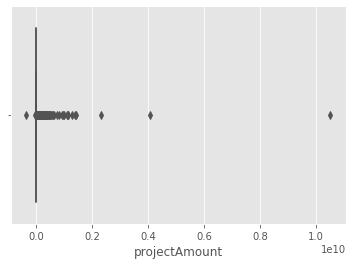

In [12]:
# Looks like projectAmount has outliers - Let's plot it
sns.boxplot(x=df['projectAmount'])

In [13]:
# Do we have nulls?
df.isna().sum()

declarationDate       0
incidentType          0
damageCategoryCode    0
state                 0
projectAmount         0
dtype: int64

In [14]:
# Change date to datetime
# Changing the date column into a datetime
df['declarationDate'] = pd.to_datetime(df['declarationDate'])
# Making a new column for year
df['year'] = df['declarationDate'].dt.year
# Making a new column for month
df['month'] = df['declarationDate'].dt.month 
# Making a new column for day
df['day'] = df['declarationDate'].dt.dayofweek

In [15]:
df = df.drop(['declarationDate', 'day', 'month'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728394 entries, 0 to 728393
Data columns (total 5 columns):
incidentType          728394 non-null object
damageCategoryCode    728394 non-null object
state                 728394 non-null object
projectAmount         728394 non-null float64
year                  728394 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 27.8+ MB


In [16]:
df['year'] = df['year'].astype('category') 

In [17]:
#Region_1 = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
#Region_2 = ['New Jersey', 'New York', 'Puerto Rico', 'Virgin Islands']
#Region_3 = ['Delaware', 'Maryland', 'Pennsylvania', 'Virginia', 'District of Columbia', 'West Virginia']
#Region_4 = ['Alabama', 'Florida', 'Georgia', 'Kentucky', 'Mississippi', 
 #           'North Carolina', 'South Carolina', 'Tennessee']
#Region_5 = ['Illinois', 'Indiana', 'Michigan', 'Minnesota', 'Ohio', 'Wisconsin']
#Region_6 = ['Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma', 'Texas']
#Region_7 = ['Iowa', 'Kansas', 'Missouri', 'Nebraska'] 
#Region_8 = ['Colorado', 'Montana', 'North Dakota', 'South Dakota', 'Utah', 'Wyoming']
#Region_9 = ['Arizona', 'California', 'Hawaii', 'Nevada', 
 #           'Guam', 'American Samoa', 'Commonwealth of Northern Mariana Islands', 
  #          'Republic of Marshall Islands', 'Federated States of Micronesia']
#Region_10 = ['Alaska', 'Idaho', 'Oregon', 'Washington']


#df['Regions'] = np.where(df['state'].isin(Atlantic_states), 'Atlantic Coast',
 #                      'Unknown')
#df.head()

# EDA/Visuals for Presentation

## Questions we can answer without linear regression?

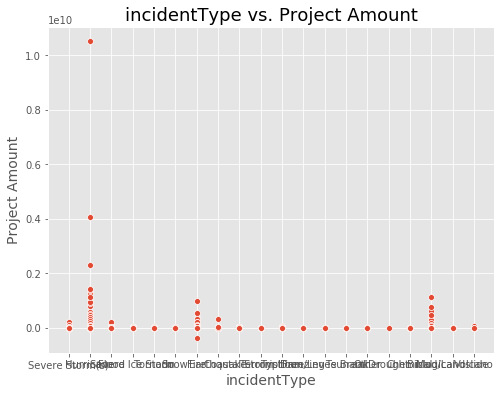

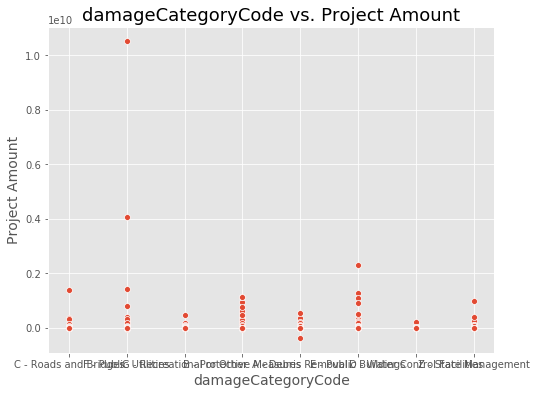

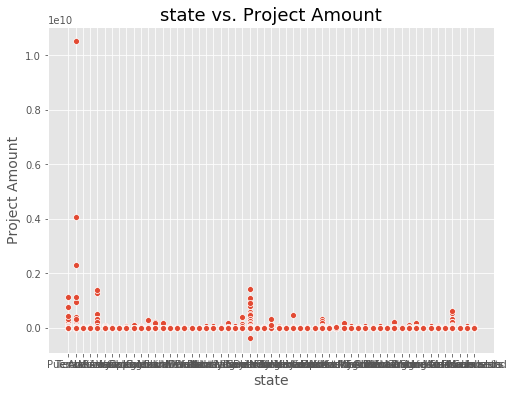

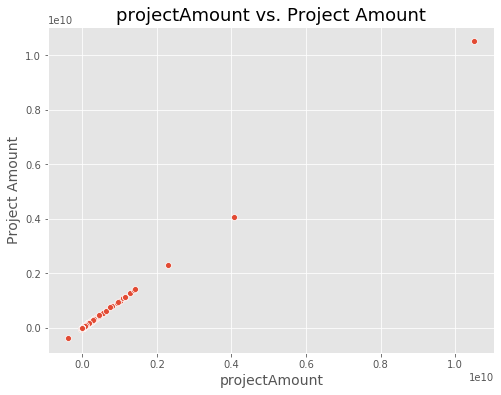

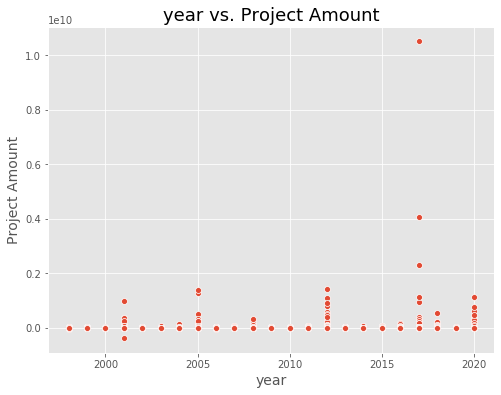

In [18]:
def scatterplot(col):
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = df[col], y = df['projectAmount'])
    ax.set_title('{} vs. Project Amount'.format(col), fontsize = 18)
    ax.set_xlabel('{}'.format(col), fontsize = 14)
    ax.set_ylabel('Project Amount', fontsize = 14);

for col in df:

    scatterplot(col)

In [19]:
# Plotting Price with the categories:
def categorical_plots(df):
    for col in df.select_dtypes('object'):
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x='projectAmount', y=col, data=df, palette="colorblind")
        ax.set_title(f"{col} vs projectAmount", fontsize=30)
        plt.xticks(rotation=45)
        plt.show()

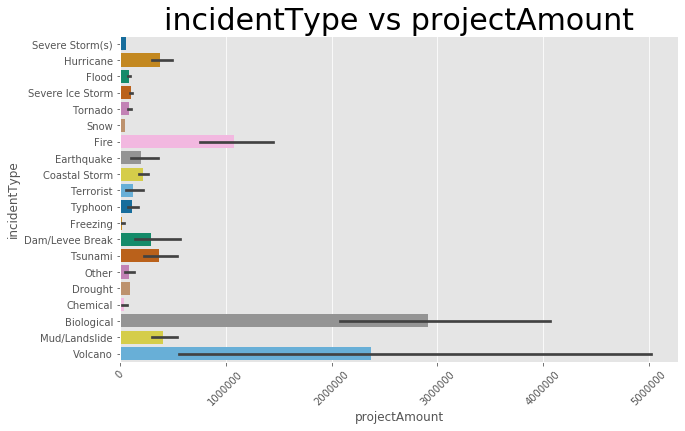

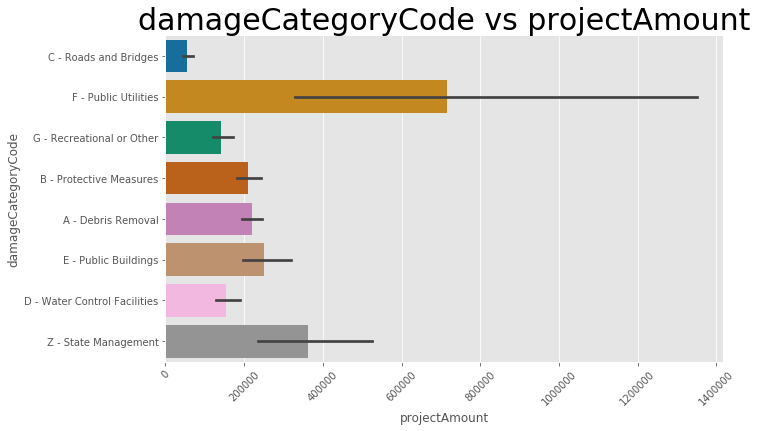

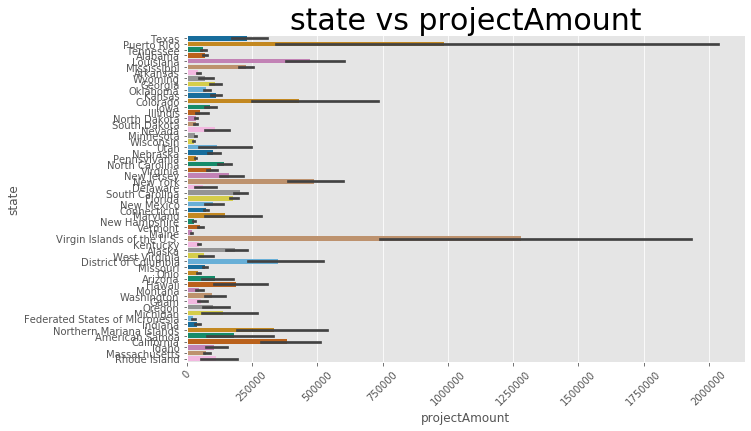

In [20]:
categorical_plots(df)

As we can see from the following vizuals above that in 2020 there was a very large increase in recovery spedning that is due to COVID-19

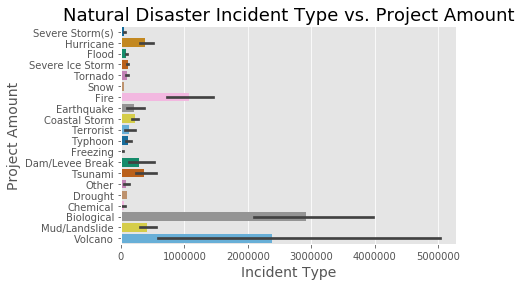

In [21]:
ax = sns.barplot(x="projectAmount", y="incidentType", data=df, palette="colorblind")
ax.set_title('Natural Disaster Incident Type vs. Project Amount', fontsize = 18)
ax.set_xlabel('Incident Type', fontsize = 14)
ax.set_ylabel('Project Amount', fontsize = 14);

# Outlier Removal

In [22]:
df['projectAmount'].value_counts()

0.000         28150
1000.000       3856
500.000        1781
5000.000       1321
2500.000       1047
              ...  
173631.320        1
2553.880          1
10297.070         1
88074.380         1
188488.930        1
Name: projectAmount, Length: 556900, dtype: int64

In [23]:
# The outliers need to be addressed
df = df[(df['projectAmount']>0)]

In [24]:
# After researching outlier removal 
# and exploring our data it is best to do IQR type outlier removal methods

def outliersiqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    threshold = iqr * 1.5
    outliers = (data < q1 - threshold) | (data > q3 + threshold)
    outliers = pd.Series(outliers, index=data.index)
    return outliers

In [25]:
# Function to make an outlier column which we will then remove outliers from
def outlierscolumn(df, columns, verbose=True):
    new_df = df.copy()
    for col in columns:
        outliers = outliersiqr(new_df[col])
        if verbose:
            print(f'{outliers.sum()} outliers found in {col}')
        new_df[f'{col}_outliers'] = outliers
    return new_df

In [26]:
# Feeding in the numerical columns for identifying outliers
num_cols = list(df.select_dtypes('number').columns)

# Saving the new dataframe with outlier columns added
df2 = outlierscolumn(df, num_cols)

92450 outliers found in projectAmount


In [27]:
df2.head()

,incidentType,damageCategoryCode,state,projectAmount,year,projectAmount_outliers
0,Severe Storm(s),C - Roads and Bridges,Texas,1489.980,1998,False
1,Severe Storm(s),C - Roads and Bridges,Texas,11300.000,1998,False
2,Severe Storm(s),C - Roads and Bridges,Texas,3486.000,1998,False
3,Severe Storm(s),F - Public Utilities,Texas,423791.130,1998,True
4,Severe Storm(s),C - Roads and Bridges,Texas,3819.670,1998,False


In [28]:
# Creating a list of the outlier columns
outliercols = []
for col in df2.columns:
    if 'outliers' in col:
        outliercols.append(col)
outliercols

['projectAmount_outliers']

In [29]:
df2.shape

(697325, 6)

In [30]:
# Dropping columns that are either continous or boolean (yes or no, has or doesn't have)
#df2= df2.drop(columns=['region_outliers', 'stateNumberCode_outliers', 'programFy_outliers'])

In [31]:
# Creating a list of the outlier columns
outliercols = []
for col in df2.columns:
    if 'outliers' in col:
        outliercols.append(col)
outliercols

['projectAmount_outliers']

In [32]:
# Filtering the outliers out of my dataframe and returning only the entries
# that are not outliers for any of the features
for col in outliercols:
    df2 = df2[(df2[col]==False)]
df2.shape

(604875, 6)

In [33]:
# Dropping the outlier columns that were added
for col in outliercols:
    df2.drop(columns=[col], axis=1, inplace=True)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604875 entries, 0 to 728393
Data columns (total 5 columns):
incidentType          604875 non-null object
damageCategoryCode    604875 non-null object
state                 604875 non-null object
projectAmount         604875 non-null float64
year                  604875 non-null category
dtypes: category(1), float64(1), object(3)
memory usage: 23.7+ MB


In [35]:
df=df2

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604875 entries, 0 to 728393
Data columns (total 5 columns):
incidentType          604875 non-null object
damageCategoryCode    604875 non-null object
state                 604875 non-null object
projectAmount         604875 non-null float64
year                  604875 non-null category
dtypes: category(1), float64(1), object(3)
memory usage: 23.7+ MB


In [37]:
# Do we have nulls?
df.isna().sum()

incidentType          0
damageCategoryCode    0
state                 0
projectAmount         0
year                  0
dtype: int64

In [38]:
df.state.value_counts()

Florida                           47544
New York                          43194
Texas                             37205
Pennsylvania                      24553
Louisiana                         23032
Iowa                              21932
Oklahoma                          20075
Arkansas                          20003
North Dakota                      19764
Missouri                          19269
Kentucky                          18465
New Jersey                        17546
Minnesota                         17537
Puerto Rico                       16840
Ohio                              14844
Illinois                          14316
North Carolina                    14264
Mississippi                       12509
California                        12415
Alabama                           12262
South Dakota                      12124
West Virginia                     11985
Tennessee                         11892
Kansas                            11457
Wisconsin                         11277


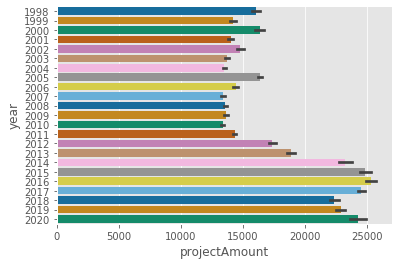

In [39]:
ax = sns.barplot(x="projectAmount", y="year", data=df, palette="colorblind")

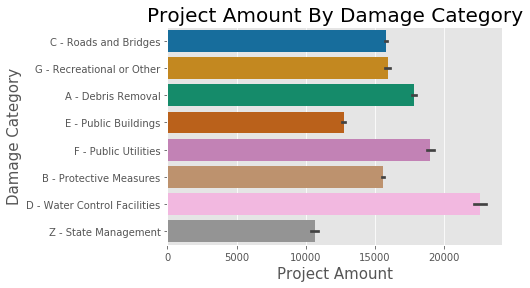

In [40]:
ax = sns.barplot(x="projectAmount", y="damageCategoryCode", data=df, palette="colorblind")
# Setting title and labels
ax.set_xlabel('Project Amount', fontsize=15)
ax.set_ylabel('Damage Category', fontsize=15)
ax.set_title('Project Amount By Damage Category', fontsize=20);

In [41]:
#df.projectIdentifier.value_counts()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604875 entries, 0 to 728393
Data columns (total 5 columns):
incidentType          604875 non-null object
damageCategoryCode    604875 non-null object
state                 604875 non-null object
projectAmount         604875 non-null float64
year                  604875 non-null category
dtypes: category(1), float64(1), object(3)
memory usage: 43.7+ MB


In [43]:
df.head()

,incidentType,damageCategoryCode,state,projectAmount,year
0,Severe Storm(s),C - Roads and Bridges,Texas,1489.980,1998
1,Severe Storm(s),C - Roads and Bridges,Texas,11300.000,1998
2,Severe Storm(s),C - Roads and Bridges,Texas,3486.000,1998
4,Severe Storm(s),C - Roads and Bridges,Texas,3819.670,1998
5,Severe Storm(s),C - Roads and Bridges,Texas,5322.680,1998


In [44]:
df.year.value_counts()

2011    75518
2008    63622
2005    50595
2004    50505
2010    42960
2009    36685
2007    36373
2003    27713
2001    24537
2006    24059
2017    23269
1999    21691
2012    18404
2002    16324
2019    14401
2000    12961
2016    12689
2013    12418
2018    11165
2015    10038
1998     8872
2014     5916
2020     4160
Name: year, dtype: int64

In [45]:
df['year'] = df['year'].astype('category') 

The following columns will be dropped because they are not relevant:
- id
- lastRefresh
- hash
- subgranteeTribalIndicator
- granteeTribalIndicator       
- 



The following columns will be dropped because they are redundant with another column:
- dateInitiallyApproved        
- dateApproved                  
- dateClosed                   

In [46]:
for col in df.columns:
    print(col, df[col].nunique())

incidentType 19
damageCategoryCode 8
state 57
projectAmount 462950
year 23


In [47]:
pd.get_dummies(df)

,projectAmount,incidentType_Biological,incidentType_Chemical,incidentType_Coastal Storm,incidentType_Dam/Levee Break,incidentType_Earthquake,incidentType_Fire,incidentType_Flood,incidentType_Freezing,incidentType_Hurricane,incidentType_Mud/Landslide,incidentType_Other,incidentType_Severe Ice Storm,incidentType_Severe Storm(s),incidentType_Snow,incidentType_Terrorist,incidentType_Tornado,incidentType_Tsunami,incidentType_Typhoon,incidentType_Volcano,damageCategoryCode_A - Debris Removal,damageCategoryCode_B - Protective Measures,damageCategoryCode_C - Roads and Bridges,damageCategoryCode_D - Water Control Facilities,damageCategoryCode_E - Public Buildings,damageCategoryCode_F - Public Utilities,damageCategoryCode_G - Recreational or Other,damageCategoryCode_Z - State Management,state_Alabama,state_Alaska,state_American Samoa,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Federated States of Micronesia,state_Florida,...,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Puerto Rico,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virgin Islands of the U.S.,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,year_1998,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,1489.980,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11300.000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3486.000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3819.670,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5322.680,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728389,5127.050,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
728390,15938.340,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
728391,77751.720,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
728392,35627.120,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Model #1

In [48]:
#Split features and target
X = df.drop(columns=['projectAmount'], axis=1)
y = df['projectAmount']

#Create function to easily build models and display results
def build_model(classifier, predictors, labels):
    '''Build classification model, returning classification report, train and test accuracy, and confusion matrix.
    
    Keyword arguments: 
    classifier -- classification algorithm
    predictors -- X, features
    labels -- y, target
    '''
    
    #Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
    #Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Create variables that can be called outside function
    build_model.X_train = X_train
    build_model.X_test = X_test
    build_model.y_train = y_train
    build_model.y_test = y_test
    
    #Fit model
    model = classifier.fit(X_train, y_train)
    score = np.mean(cross_val_score(classifier, X, y, cv=5, scoring='recall'))

    #Create predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    #Create variables that can be called outside function
    build_model.y_hat_train = y_hat_train
    build_model.y_hat_test = y_hat_test
    
    #Print classification report
    print('Train Classification Report\n', classification_report(y_train, y_hat_train))
    print('Test Classification Report\n', classification_report(y_test, y_hat_test))
    
    print('Train Accuracy:', round(accuracy_score(y_train, y_hat_train), 3))
    print('Test Accuracy:', round(accuracy_score(y_test, y_hat_test), 3))
    print('Cross Validation Recall', round(score, 3))
    
    #Create a results dataframe
    results = pd.DataFrame([[str(model), round(accuracy_score(y_train, y_hat_train), 3), 
                             round(accuracy_score(y_test, y_hat_test), 3), round(score, 3)]], 
                          columns=['Model', 'Train_Accuracy', 'Test_Accuracy', 'Cross_Val_Recall'])
    build_model.results = results
    
    #Plot Confusion Matrices
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    plot_confusion_matrix(classifier, X_train, y_train,
                     cmap=plt.cm.Blues, ax=axes[0])
    fig.suptitle('Train & Test Confusion Matrices', fontsize=16);
    
    plot_confusion_matrix(classifier, X_test, y_test,
                     cmap=plt.cm.Blues, ax=axes[1])
    plt.subplots_adjust(wspace=0.4)
    return model    

In [49]:
features = '+'.join(df.drop('projectAmount', axis = 1).columns)
formula = 'projectAmount ~' + features
model1 = smf.ols(formula, df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          projectAmount   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     432.6
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:23:46   Log-Likelihood:            -6.7558e+06
No. Observations:              604875   AIC:                         1.351e+07
Df Residuals:                  604771   BIC:                         1.351e+07
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                           1.399e+04    627.165     22.299      0.000    1.28e+04    1.52e+04
incidentType[T.Chemical]                           -4752.5379   2552.496     -1.862      0.063   -9755.348     250.272
incidentType[T.Coastal Storm]                       -976.7489    672.730     -1.452      0.147   -2295.278     341.780
incidentType[T.Dam/Levee Break]                     3221.3278   2126.734      1.515      0.130    -947.002    7389.658
incidentType[T.Earthquake]                          -212.4426    657.848     -0.323      0.747   -1501.804    1076.919
incidentType[T.Fire]                                -718.1904    601.691     -1.194      0.233   -1897.485     461.104
incidentType[T.Flood]                              -1164.3790    558.782     -2.084      0.037   -2259.574     -69.184
incidentType[T.Freezing]                            -861.4159   1373.878     -0.627      0.531   -3554.172    1831.341
incidentType[T.Hurricane]                           -856.2047    559.497     -1.530      0.126   -1952.800     240.391
incidentType[T.Mud/Landslide]                      -2925.6490   1642.782     -1.781      0.075   -6145.450     294.152
incidentType[T.Other]                              -1244.4405    795.693     -1.564      0.118   -2803.973     315.092
incidentType[T.Severe Ice Storm]                    1446.2142    571.103      2.532      0.011     326.870    2565.558
incidentType[T.Severe Storm(s)]                    -1884.9309    554.861     -3.397      0.001   -2972.441    -797.421
incidentType[T.Snow]                                -116.8883    562.102     -0.208      0.835   -1218.590     984.813
incidentType[T.Terrorist]                           4682.7088   1926.781      2.430      0.015     906.280    8459.138
incidentType[T.Tornado]                            -1544.1373    608.220     -2.539      0.011   -2736.228    -352.047
incidentType[T.Tsunami]                             2391.8864   1826.313      1.310      0.190   -1187.628    5971.401
incidentType[T.Typhoon]                             3008.4150   1071.927      2.807      0.005     907.473    5109.357
incidentType[T.Volcano]                            -3656.5301   3824.005     -0.956      0.339   -1.12e+04    3838.397
damageCategoryCode[T.B - Protective Measures]      -2389.9015     83.860    -28.499      0.000   -2554.265   -2225.538
damageCategoryCode[T.C - Roads and Bridges]            4.4879     81.222      0.055      0.956    -154.704     163.680
damageCategoryCode[T.D - Water Control Facilities]  4934.0863    192.788     25.593      0.000    4556.228    5311.945
damageCategoryCode[T.E - Public Buildings]         -6101.5750     94.982    -64.239      0.000   -6287.737  

In [50]:
model1.params

Intercept                         13985.015
incidentType[T.Chemical]          -4752.538
incidentType[T.Coastal Storm]      -976.749
incidentType[T.Dam/Levee Break]    3221.328
incidentType[T.Earthquake]         -212.443
                                     ...   
year[T.2016]                      12758.438
year[T.2017]                      11439.559
year[T.2018]                      12077.373
year[T.2019]                      12669.131
year[T.2020]                      12416.865
Length: 104, dtype: float64

<Figure size 864x432 with 0 Axes>

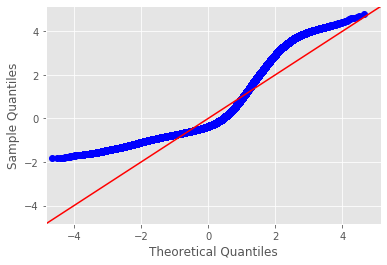

In [51]:
# QQ plot to see if our data is linear
fig1 = plt.figure(figsize = (12,6))
fig1 = sm.graphics.qqplot(model1.resid,fit=True, line='45');

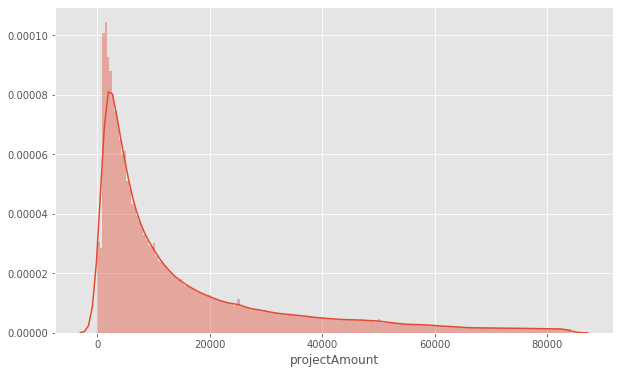

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(df['projectAmount'], bins='auto')

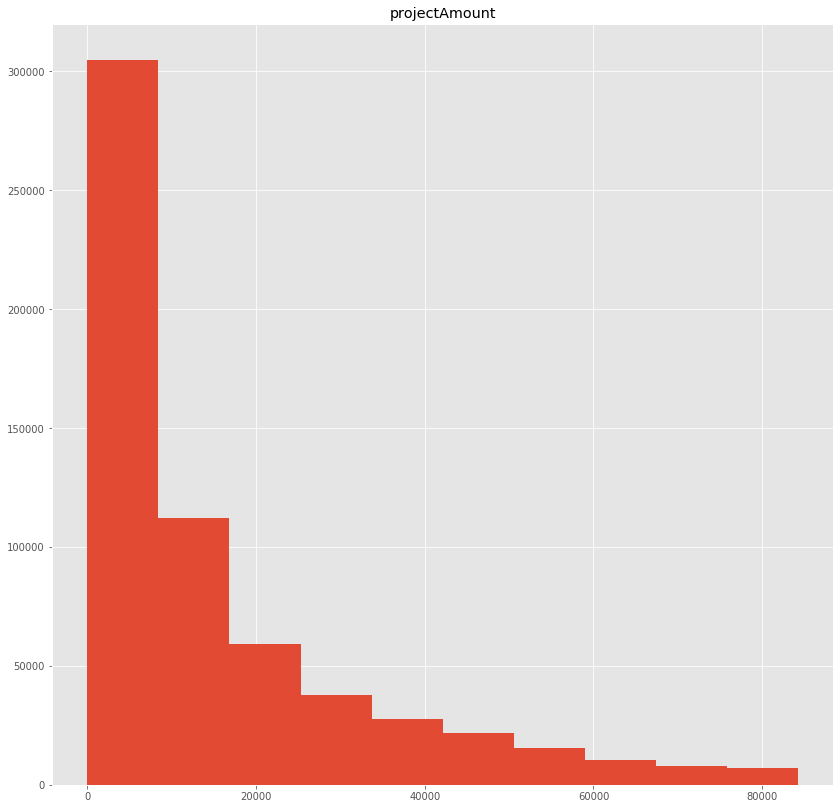

In [53]:
df.hist(figsize = (14,14));

In [54]:
# Function to make vizuals to show normality
#def normalityplots (df, column):
 ##   plt.figure(figsize = (12,4))
   # plt.subplot(1,2,1)
    #df[column].hist(bins = 30)
 #   plt.subplot(1,2,2)
  #  stats.probplot(df[column], dist = 'norm', plot = plt)
   # plt.title('{}'.format(column))
    #plt.show()

# Now let's see the results of the outlier removal
#for column in df.columns:
 #   try: 
  #      normalityplots(df, column)
   # except: 
    #    print(column)

In [55]:
def model_fun(df, target='projectAmount', test_size=0.25):
    X = df.drop([target], axis=1)
    y = df[[target]]    
# Defining training test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=123)
# Defining df with the split data
    df_train = pd.concat([y_train, X_train], axis=1)
    df_test = pd.concat([y_test, X_test], axis=1) 
# Getting the categorical columns
    cat_cols = df_train.select_dtypes('object').columns
# Making the model summary
    features = '+'.join(df_train.drop(columns=target).columns)
# Looping through categoricals to make the formula
    for col in cat_cols:
        features = features.replace(col,f'C({col})')   
    formula = target + '~' + features
    model = smf.ols(formula, df_train).fit()
# QQ plot of the residuals for normality
    fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=axes[0])
    axes[0].set_title('QQ Plot of Residuals', fontsize=20)
# Homoscedasticity of Residuals
    ax=axes[1]
    ax.scatter(df_train['projectAmount'], model.resid)
    ax.axhline(0, color='red')
    axes[1].set_title('Homoscedasticity of Residuals', fontsize=20)
    plt.show();
# Getting the predicted y values from the model
    y_predicted = model.predict(X_test)
    
# Plotting a scatterplot of the training vs original test data prices e
    plt.figure(figsize=(20,5))
    g = sns.scatterplot(range(len(y_predicted[:200])), y_predicted[:200], 
                        label='Predicted Prices')
    g = sns.scatterplot(range(len(y_test[:200])), y_test.projectAmount[:200], 
                        label='Actual Prices')

# Visual titles, labels, and legends of the plots
    plt.title('Comparison of predicted vs actual price', 
              fontdict={'fontsize':20})
    plt.xlabel('Values')
    plt.ylabel('Amount')
    plt.legend()
    plt.show();
# Generating the r2 for the test data to compare to the train data 
    r2_test = r2_score(y_test, y_predicted)
    print('Model test data R2 score:', r2_test)
# Displaying everything
    display(model.summary())
    return model

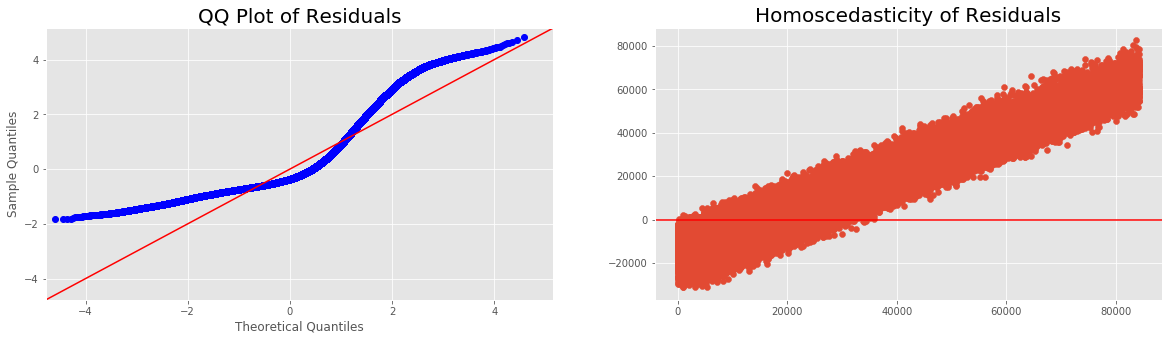

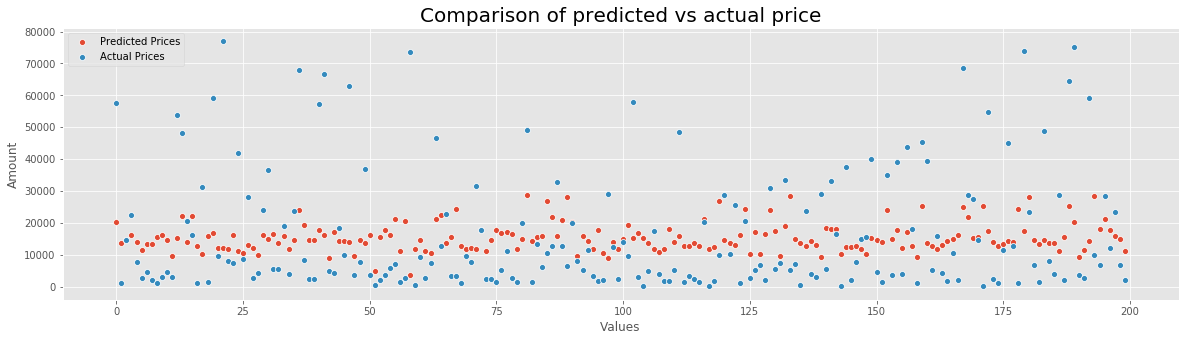

Model test data R2 score: 0.06684793649473564


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          projectAmount   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     327.1
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:24:44   Log-Likelihood:            -5.0665e+06
No. Observations:              453656   AIC:                         1.013e+07
Df Residuals:                  453552   BIC:                         1.013e+07
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              1.426e+04    723.748     19.704      0.000    1.28e+04    1.57e+04
C(incidentType)[T.Chemical]                           -6782.2242   2871.058     -2.362      0.018   -1.24e+04   -1155.039
C(incidentType)[T.Coastal Storm]                      -1166.0674    776.067     -1.503      0.133   -2687.134     354.999
C(incidentType)[T.Dam/Levee Break]                     3201.5015   2500.891      1.280      0.200   -1700.168    8103.171
C(incidentType)[T.Earthquake]                            67.9733    760.075      0.089      0.929   -1421.751    1557.697
C(incidentType)[T.Fire]                                -842.2612    694.568     -1.213      0.225   -2203.593     519.071
C(incidentType)[T.Flood]                              -1329.5257    644.813     -2.062      0.039   -2593.340     -65.711
C(incidentType)[T.Freezing]                            -571.7666   1577.176     -0.363      0.717   -3662.982    2519.449
C(incidentType)[T.Hurricane]                           -983.9266    645.680     -1.524      0.128   -2249.440     281.587
C(incidentType)[T.Mud/Landslide]                      -3741.7771   1922.900     -1.946      0.052   -7510.603      27.049
C(incidentType)[T.Other]                              -1644.2860    919.877     -1.788      0.074   -3447.216     158.644
C(incidentType)[T.Severe Ice Storm]                    1328.8371    658.995      2.016      0.044      37.227    2620.448
C(incidentType)[T.Severe Storm(s)]                    -2107.4774    640.369     -3.291      0.001   -3362.581    -852.374
C(incidentType)[T.Snow]                                -392.4157    648.701     -0.605      0.545   -1663.850     879.018
C(incidentType)[T.Terrorist]                           4329.4557   2196.443      1.971      0.049      24.495    8634.417
C(incidentType)[T.Tornado]                            -2033.1544    702.309     -2.895      0.004   -3409.659    -656.650
C(incidentType)[T.Tsunami]                             4250.9698   2237.974      1.899      0.058    -135.390    8637.329
C(incidentType)[T.Typhoon]                             2396.7235   1242.339      1.929      0.054     -38.222    4831.669
C(incidentType)[T.Volcano]                            -7090.1584   4516.800     -1.570      0.116   -1.59e+04    1762.630
C(damageCategoryCode)[T.B - Protective Measures]      -2360.8921     96.727    -24.408      0.000   -2550.475   -2171.310
C(damageCategoryCode)[T.C - Roads and Bridges]           40.4114     93.642      0.432      0.666    -143.124     223.946
C(damageCategoryCode)[T.D - Water Control Facilities]  4879.1274    222.200     21.958      0.000    4443.622    5314.633
C(damageCategoryCode)[T.E - Publi

In [56]:
functionmodel1 = model_fun(df)

# Hypertuning

## Low p-value removal

In [57]:
# Function to identify the insignificant p-values
def bad_pvalues(model, verbose=True):
    
#     Pulling out the p-values and identifying the ones above .05
    pvalues = model.pvalues
    bad_features = pvalues[pvalues > .05]
    
#     Excluding the intercept in case it has a high p-value
    if 'Intercept' in bad_features:
        bad_features.remove('Intercept')
        
#      Printing a statement of the bad p-values
    if verbose:
        print(f'{len(bad_features)} bad p-values to be reviewed:\n' 
              + f'{bad_features}')
    return bad_features

In [58]:
model2_bad_pvals = bad_pvalues(model1)

23 bad p-values to be reviewed:
incidentType[T.Chemical]                      0.063
incidentType[T.Coastal Storm]                 0.147
incidentType[T.Dam/Levee Break]               0.130
incidentType[T.Earthquake]                    0.747
incidentType[T.Fire]                          0.233
incidentType[T.Freezing]                      0.531
incidentType[T.Hurricane]                     0.126
incidentType[T.Mud/Landslide]                 0.075
incidentType[T.Other]                         0.118
incidentType[T.Snow]                          0.835
incidentType[T.Tsunami]                       0.190
incidentType[T.Volcano]                       0.339
damageCategoryCode[T.C - Roads and Bridges]   0.956
state[T.Federated States of Micronesia]       0.516
state[T.Guam]                                 0.470
state[T.Indiana]                              0.592
state[T.Kentucky]                             0.167
state[T.Northern Mariana Islands]             0.668
state[T.Ohio]                   

Even though incidentType and state has bad p-values I don't want to remove it as it is an important feature to analyse.

Instead I think it would be best to do other tuning  including outlier removal later on

# Model #2

## Multicolinearity Column/Feature Removal

In [59]:
# Creating a heat map again to see our new data
corr3 = df.iloc[:,2:] 
corr3.corr().abs().style.background_gradient(cmap='Reds')

,projectAmount
projectAmount,1


There also aren't any significant correlation issues

## Removing more extreme outliers

In [60]:
def outliersiqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    threshold = iqr * 1.5
    outliers = (data < q1 - threshold) | (data > q3 + threshold)
    outliers = pd.Series(outliers, index=data.index)
    return outliers

In [61]:
# Feeding in the numerical columns for identifying outliers
num_cols = list(df.select_dtypes('number').columns)

# Saving the new dataframe with outlier columns added
df4 = outlierscolumn(df, num_cols)

45161 outliers found in projectAmount


In [62]:
df4.head()

,incidentType,damageCategoryCode,state,projectAmount,year,projectAmount_outliers
0,Severe Storm(s),C - Roads and Bridges,Texas,1489.980,1998,False
1,Severe Storm(s),C - Roads and Bridges,Texas,11300.000,1998,False
2,Severe Storm(s),C - Roads and Bridges,Texas,3486.000,1998,False
4,Severe Storm(s),C - Roads and Bridges,Texas,3819.670,1998,False
5,Severe Storm(s),C - Roads and Bridges,Texas,5322.680,1998,False


In [63]:
# Creating a list of the outlier columns
outliercols = []
for col in df4.columns:
    if 'outliers' in col:
        outliercols.append(col)
outliercols

['projectAmount_outliers']

In [64]:
# Creating a list of the outlier columns
outliercols = []
for col in df4.columns:
    if 'outliers' in col:
        outliercols.append(col)
outliercols

['projectAmount_outliers']

In [65]:
# Filtering the outliers out of my dataframe and returning only the entries
# that are not outliers for any of the features
for col in outliercols:
    df4 = df4[(df4[col]==False)]
df4.shape

(559714, 6)

In [66]:
# Dropping the outlier columns that were added
for col in outliercols:
    df4.drop(columns=[col], axis=1, inplace=True)

In [67]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559714 entries, 0 to 728393
Data columns (total 5 columns):
incidentType          559714 non-null object
damageCategoryCode    559714 non-null object
state                 559714 non-null object
projectAmount         559714 non-null float64
year                  559714 non-null category
dtypes: category(1), float64(1), object(3)
memory usage: 21.9+ MB


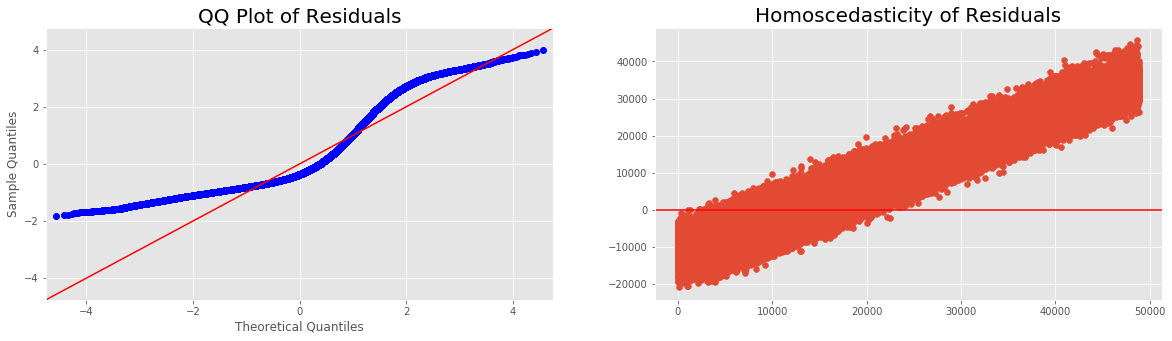

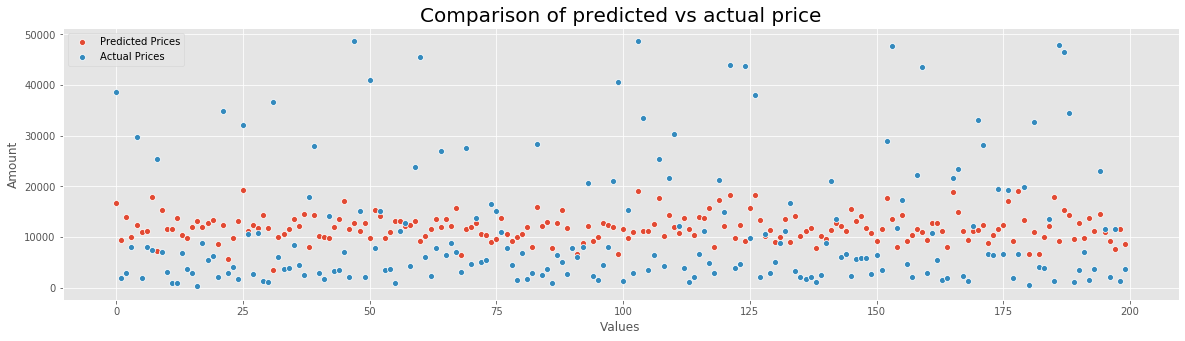

Model test data R2 score: 0.05779350827933738


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          projectAmount   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     245.0
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:25:30   Log-Likelihood:            -4.5184e+06
No. Observations:              419785   AIC:                         9.037e+06
Df Residuals:                  419681   BIC:                         9.038e+06
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              1.198e+04    518.479     23.114      0.000     1.1e+04     1.3e+04
C(incidentType)[T.Chemical]                            -401.7522   2028.042     -0.198      0.843   -4376.654    3573.149
C(incidentType)[T.Coastal Storm]                      -1635.6182    553.699     -2.954      0.003   -2720.852    -550.384
C(incidentType)[T.Dam/Levee Break]                     2139.9148   1781.789      1.201      0.230   -1352.337    5632.167
C(incidentType)[T.Earthquake]                          -513.1948    542.405     -0.946      0.344   -1576.293     549.903
C(incidentType)[T.Fire]                               -1260.8588    499.684     -2.523      0.012   -2240.224    -281.494
C(incidentType)[T.Flood]                              -1068.2876    465.753     -2.294      0.022   -1981.150    -155.425
C(incidentType)[T.Freezing]                             113.0766   1061.641      0.107      0.915   -1967.707    2193.860
C(incidentType)[T.Hurricane]                          -1002.6091    466.266     -2.150      0.032   -1916.476     -88.742
C(incidentType)[T.Mud/Landslide]                        371.8100   1295.805      0.287      0.774   -2167.928    2911.548
C(incidentType)[T.Other]                              -1387.3137    646.259     -2.147      0.032   -2653.962    -120.666
C(incidentType)[T.Severe Ice Storm]                     548.4437    475.186      1.154      0.248    -382.906    1479.793
C(incidentType)[T.Severe Storm(s)]                    -1441.9640    462.630     -3.117      0.002   -2348.704    -535.224
C(incidentType)[T.Snow]                                -433.3996    468.251     -0.926      0.355   -1351.158     484.358
C(incidentType)[T.Terrorist]                           3062.7265   1552.073      1.973      0.048      20.711    6104.742
C(incidentType)[T.Tornado]                            -1658.7996    503.368     -3.295      0.001   -2645.386    -672.213
C(incidentType)[T.Tsunami]                             1658.2377   1452.926      1.141      0.254   -1189.453    4505.928
C(incidentType)[T.Typhoon]                             1592.6650    860.625      1.851      0.064     -94.134    3279.464
C(incidentType)[T.Volcano]                            -4962.7771   3021.699     -1.642      0.101   -1.09e+04     959.661
C(damageCategoryCode)[T.B - Protective Measures]      -1434.9529     67.598    -21.228      0.000   -1567.443   -1302.462
C(damageCategoryCode)[T.C - Roads and Bridges]          763.2615     65.475     11.657      0.000     634.932     891.591
C(damageCategoryCode)[T.D - Water Control Facilities]  2971.9900    159.297     18.657      0.000    2659.774    3284.206
C(damageCategoryCode)[T.E - Publi

In [68]:
# Model summary to see the changes if significant
functionmodel4 = model_fun(df4)

Even though we have signifcantly reduced the size of our dataset we have created a better model to work off of

In [69]:
functionmodel4.params

Intercept                            11983.980
C(incidentType)[T.Chemical]           -401.752
C(incidentType)[T.Coastal Storm]     -1635.618
C(incidentType)[T.Dam/Levee Break]    2139.915
C(incidentType)[T.Earthquake]         -513.195
                                        ...   
year[T.2016]                          6616.246
year[T.2017]                          5723.492
year[T.2018]                          5963.014
year[T.2019]                          6445.081
year[T.2020]                          5982.013
Length: 104, dtype: float64

IncidentType is the largest determing factor in program cost while program areas are the least effective to the model

In [70]:
# Convert the coefficient series to a sorted dataframe

coeffs_df = functionmodel4.params.to_frame()
coeffs_df.columns = ['coefficients']
coeffs_df = coeffs_df.sort_values('coefficients', ascending = False)
coeffs_df.style.background_gradient(cmap = 'Reds').set_caption('Coefficients')

,coefficients
Intercept,11984
year[T.2016],6616.25
year[T.2019],6445.08
year[T.2015],6306.52
year[T.2020],5982.01
year[T.2018],5963.01
year[T.2017],5723.49
C(state)[T.Alaska],5409.94
year[T.2014],5282.8
C(state)[T.District of Columbia],4610.29


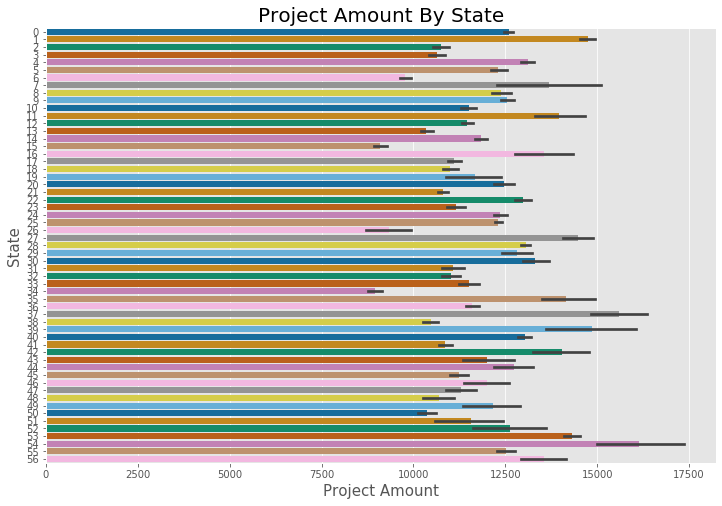

In [71]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='projectAmount', y='state', data=df4, palette="colorblind")

# Formatting the y-axis ticks to show as money
fmt_money = '{x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Project Amount', fontsize=15)
ax.set_ylabel('State', fontsize=15)
ax.set_title('Project Amount By State', fontsize=20);

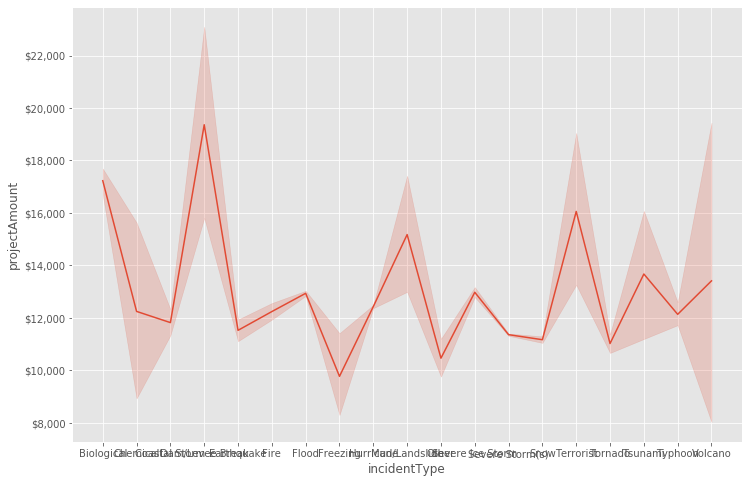

In [72]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(df4['incidentType'], df4['projectAmount'])

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

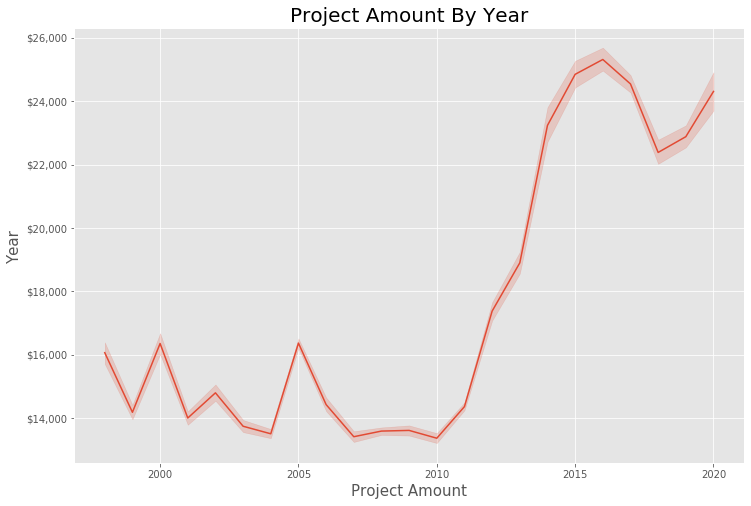

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(df['year'], df['projectAmount'])

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Project Amount', fontsize=15)
ax.set_ylabel('Year', fontsize=15)
ax.set_title('Project Amount By Year', fontsize=20);

# EDA/Visuals for Presentation

In [74]:
# I want to try to create visuals with our original 
# data before it was edited to get a real picture of recovery costs

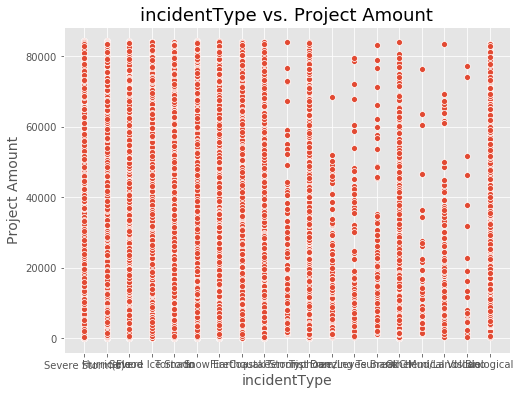

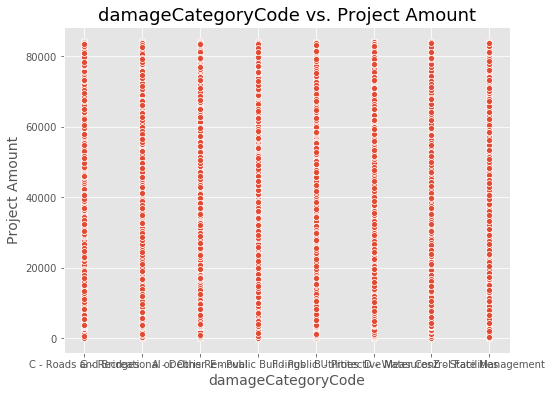

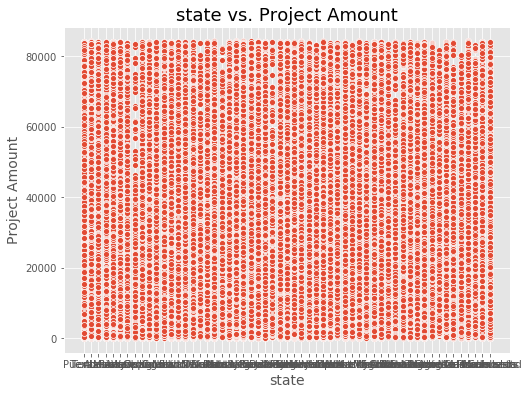

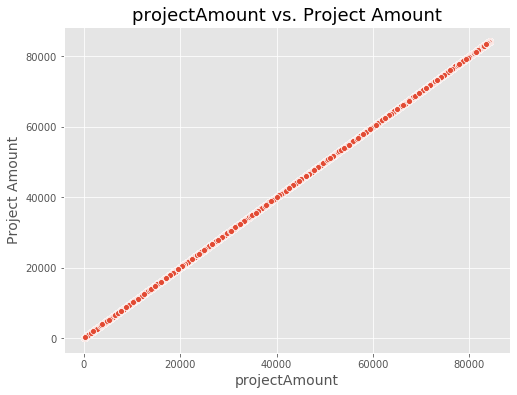

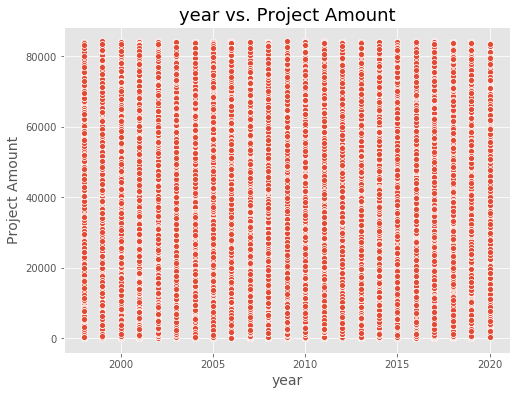

In [75]:
def scatterplot(col):
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = df[col], y = df['projectAmount'])
    ax.set_title('{} vs. Project Amount'.format(col), fontsize = 18)
    ax.set_xlabel('{}'.format(col), fontsize = 14)
    ax.set_ylabel('Project Amount', fontsize = 14);

for col in df:

    scatterplot(col)

In [76]:
# Plotting Price with the categories:
def categorical_plots(df):
    for col in df.select_dtypes('object'):
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=col, y='projectAmount', data=df, palette="colorblind")
        ax.set_title(f"{col} vs projectAmount", fontsize=30)
        plt.xticks(rotation=45)
        plt.show()

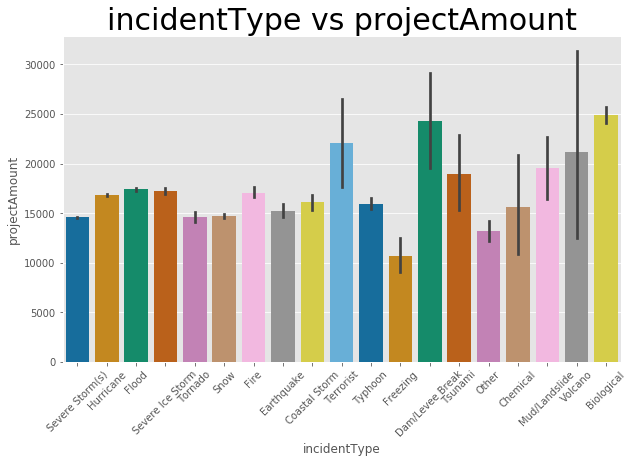

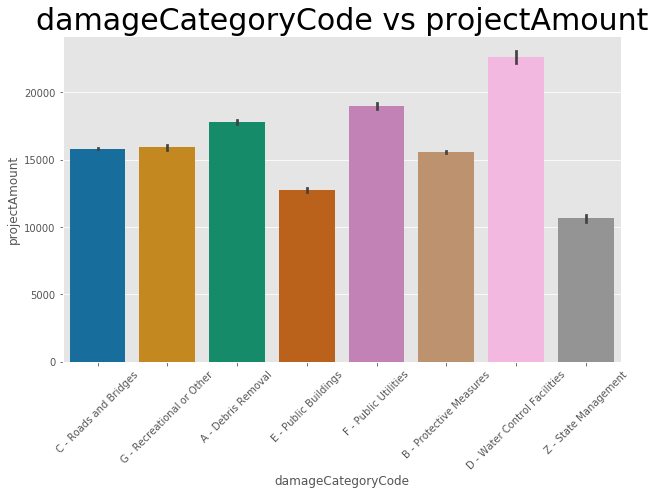

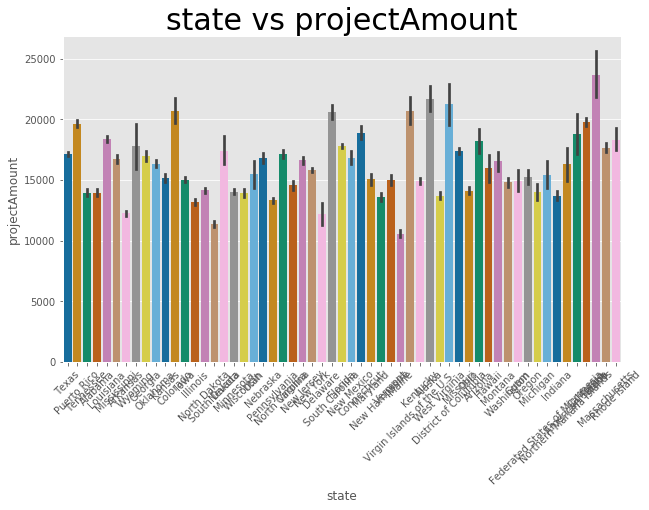

In [77]:
categorical_plots(df)

# Conclusions

**Budgets should be analyzed to understand what regions of the U.S. should receive more funding over other regions with higher risk to natural disaster costs**
- Alaska, DC, Arizona, Louisiana, Puerto Rico, Idaho
- Coastal areas need more funding than those of the Mid West**
